In [43]:
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from ISLP import load_data
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from pygam import s as s_gam, l as l_gam, f as f_gam, LinearGAM, LogisticGAM
import matplotlib.pyplot as plt
import numpy as np

In [34]:
college_df = load_data("College")
college_df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [35]:
cols_preprocessing = make_column_transformer(
    (OneHotEncoder(sparse_output=False, drop="if_binary"), ["Private"]),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")

college_df = cols_preprocessing.fit_transform(college_df.copy())

In [36]:
college_df.head()

,Private_Yes,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,1.0,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1.0,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1.0,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,1.0,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,1.0,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


### a)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    college_df.drop("Outstate", axis=1),
    college_df["Outstate"],
    test_size=0.2,
    random_state=1,
)

In [64]:
feature_selection = SequentialFeatureSelector(
    LinearRegression(),
    n_features_to_select="auto",
    tol=25,
    direction="forward",
    cv=5,
    scoring="neg_root_mean_squared_error",
).set_output(transform="pandas")

result_feature_selection = feature_selection.fit_transform(X_train, y_train)

In [65]:
result_feature_selection.head()

,Private_Yes,Room.Board,PhD,perc.alumni,Expend,Grad.Rate
575,1.0,6000,91,48,18953,61
194,1.0,3450,62,31,9552,53
339,1.0,6550,97,24,11291,70
310,1.0,4000,88,20,8539,66
739,0.0,2890,33,10,4249,60


### b)

In [71]:
X_array = result_feature_selection.to_numpy()
gam = LinearGAM(f_gam(0, lam=0) + s_gam(1) + s_gam(2) + s_gam(3) + s_gam(4) + s_gam(5))
gam.fit(X_array, y_train)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + intercept, 
   tol=0.0001, verbose=False)

In [73]:
selected_columns = result_feature_selection.columns
y_pred = gam.predict(X_test[selected_columns])
mean_squared_error(y_test, y_pred)

3847352.448018415

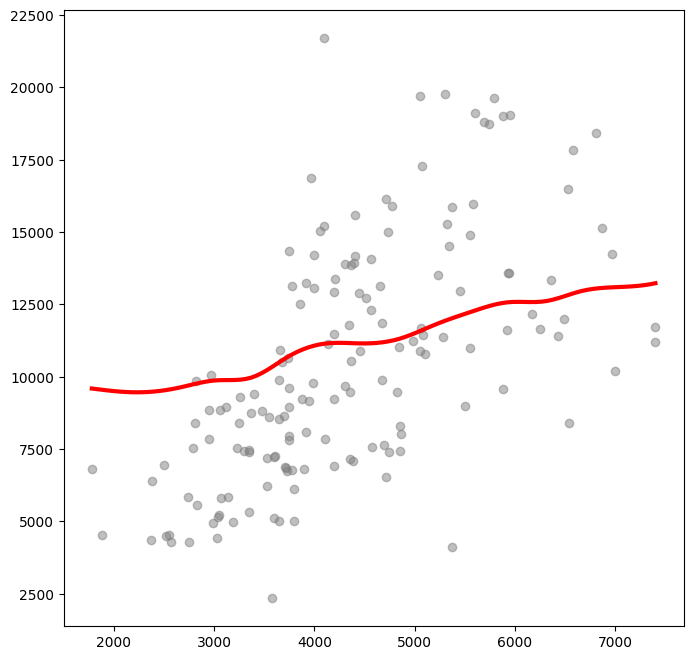

In [82]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x=X_test["Room.Board"], y=y_test, facecolor="gray", alpha=0.5)

RoomBoard_grid = np.linspace(X_test["Room.Board"].min(), X_test["Room.Board"].max(), 100)

RoomBoard_df = pd.DataFrame(
    {
        "Private_Yes": 1.0,
        "Room.Board": RoomBoard_grid,
        "PhD": X_train["PhD"].mean(),
        "perc.alumni": X_train["perc.alumni"].mean(),
        "Expend": X_train["Expend"].mean(),
        "Grad.Rate": X_train["Grad.Rate"].mean(),
    }
)
preds = gam.predict(RoomBoard_df)

ax.plot(RoomBoard_grid, preds, color="red", linewidth=3)
plt.show()

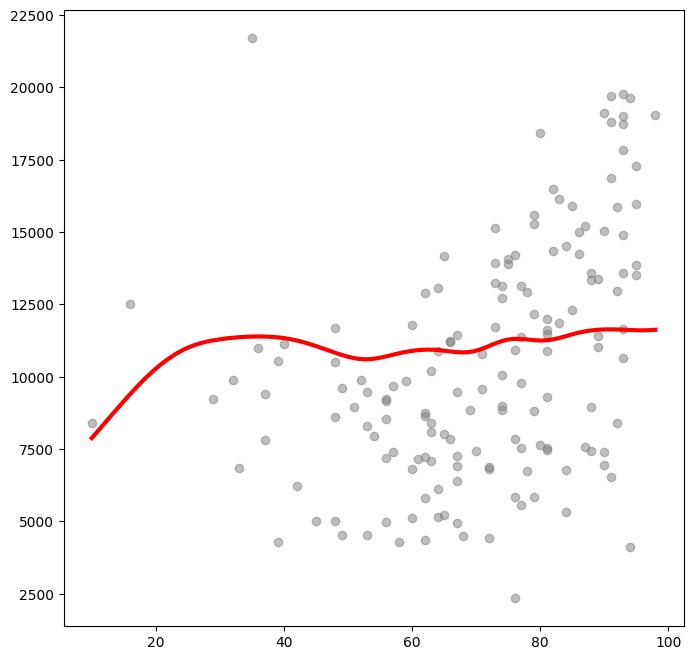

In [84]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x=X_test["PhD"], y=y_test, facecolor="gray", alpha=0.5)

PhD_grid = np.linspace(X_test["PhD"].min(), X_test["PhD"].max(), 100)

PhD_df = pd.DataFrame(
    {
        "Private_Yes": 1.0,
        "Room.Board": X_train["Room.Board"].mean(),
        "PhD": PhD_grid,
        "perc.alumni": X_train["perc.alumni"].mean(),
        "Expend": X_train["Expend"].mean(),
        "Grad.Rate": X_train["Grad.Rate"].mean(),
    }
)
preds = gam.predict(PhD_df)

ax.plot(PhD_grid, preds, color="red", linewidth=3)
plt.show()